In [2]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

pd.set_option('display.float_format', lambda x : '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import optuna

import joblib
import math

/home/orlandojunior/miniconda3/envs/rocketseat_ia/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Abrir Base Cliente

In [3]:
df_clientes = pd.read_csv('./clientes.csv')

In [4]:
df_clientes.info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   str    
 1   Nome                         1000 non-null   str    
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   str    
 13  Cargo                        1

In [5]:
df_clientes.head()

,ID_Cliente,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score,Principal Cartão
0,bc3749c2-932f-462b-a71e-d1a352510f67,Nicole Lopes,32,5,4,2,4,5,3,1,2,4,Brasília,Engenheiro agrônomo,Divorciado,4,2,Próprio,True,34118,631262,55649,294254,0.00000,232,Rocketseat Mastercard Travel Elite
1,981dffc4-087e-4a99-bbac-062944f9b5a7,Kevin Teixeira,42,1,4,5,1,4,1,5,3,5,Campo Grande,Psicólogo,Divorciado,18,2,Alugado,True,7338,376417,1777324,180331,87.00000,27,Rocketseat Mastercard Life Basic
2,242f4e94-7f2a-4557-a27a-9227cca55e83,Augusto Sá,67,4,3,4,3,2,3,3,2,3,Goiânia,Intérprete de Bíblias,Solteiro,19,6,Alugado,True,19965,83667,1793731,122049,78.45000,57,Rocketseat Mastercard Travel Basic
3,e6f16b89-d9bf-4448-9d08-65957cdc1fb3,Ágatha Moura,47,2,3,1,2,1,3,4,3,1,Porto Alegre,Engenheiro de projetos,Divorciado,6,6,Próprio,False,25867,283060,1940685,335544,85.21000,32,Rocketseat Visa Travel Basic
4,79b7f5b0-e754-4cd9-9150-ed5913fef23a,João Rios,27,3,5,4,5,4,3,2,2,5,Fortaleza,Cantor,Solteiro,1,1,Alugado,True,18359,146413,517215,390588,89.12000,0,Rocketseat Visa Life Basic


## Mostrar estatisticas das variáveis numericas

In [7]:
df_clientes.drop(columns=['ID_Cliente', 'Nome'], inplace=True)

In [8]:
num_vars = df_clientes.select_dtypes(include=['number']).columns
cat_vars = df_clientes.select_dtypes(include=['object']).columns
target = 'Probabilidade Inadimplencia'
display(df_clientes[num_vars].describe().T)

/tmp/ipykernel_277152/2634508423.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_vars = df_clientes.select_dtypes(include=['object']).columns


,count,mean,std,min,25%,50%,75%,max
Idade,1000.00000,49.43200,18.31980,18.00000,34.00000,49.00000,66.00000,80.00000
Viagens,1000.00000,2.98600,1.40277,1.00000,2.00000,3.00000,4.00000,5.00000
Restaurantes,1000.00000,3.02300,1.41791,1.00000,2.00000,3.00000,4.00000,5.00000
Entretenimento,1000.00000,3.07300,1.39198,1.00000,2.00000,3.00000,4.00000,5.00000
Cashback,1000.00000,2.98500,1.38878,1.00000,2.00000,3.00000,4.00000,5.00000
Compras online,1000.00000,2.99900,1.42303,1.00000,2.00000,3.00000,4.00000,5.00000
Farmácias,1000.00000,2.97900,1.38437,1.00000,2.00000,3.00000,4.00000,5.00000
Programas de Milhagem,1000.00000,3.00300,1.45984,1.00000,2.00000,3.00000,4.00000,5.00000
Postos de Combustível,1000.00000,3.09100,1.43205,1.00000,2.00000,3.00000,4.00000,5.00000
Mercados,1000.00000,3.00100,1.43912,1.00000,2.00000,3.00000,4.00000,5.00000


In [10]:
for col in cat_vars:
    print(f'\n{col}: {df_clientes[col].nunique()} valores únicos')
    print(df_clientes[col].value_counts().head())


Cidade: 15 valores únicos
Cidade
Goiânia           77
Porto Alegre      74
Rio de Janeiro    74
São Paulo         73
Florianópolis     72
Name: count, dtype: int64

Cargo: 565 valores únicos
Cargo
Comandante                    6
Gestor de recursos humanos    6
Ferramenteiro                 5
Vistoriador de sinistros      5
Jogador de badminton          5
Name: count, dtype: int64

Estado Civil: 4 valores únicos
Estado Civil
Casado        259
Viúvo         257
Divorciado    247
Solteiro      237
Name: count, dtype: int64

Moradia: 2 valores únicos
Moradia
Próprio    507
Alugado    493
Name: count, dtype: int64

Principal Cartão: 24 valores únicos
Principal Cartão
Rocketseat Mastercard Life Basic        149
Rocketseat Visa Life Basic              132
Rocketseat Mastercard Travel Basic      108
Rocketseat Visa Travel Basic             92
Rocketseat Mastercard Shopping Basic     92
Name: count, dtype: int64


In [13]:
num_cols = 3

num_rows = math.ceil(len(num_vars)/num_cols)

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

for i, var in enumerate(num_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    fig.add_trace(
        go.Histogram(x=df_clientes[var], name=var),
        row=row, col=col
    )

fig.update_layout(
    height=300 * num_rows,
    width=1200,
    title_text='Histograma das Variáveis Numéricas',
    showlegend=False
)

fig.show()

## Variáveis categóricas

In [16]:
num_cols = 3

num_rows = math.ceil(len(num_vars)/num_cols)

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

for i, var in enumerate(cat_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    fig.add_trace(
        go.Bar(x=df_clientes[var].value_counts().index[:10],
               y=df_clientes[var].value_counts().values[:10],
               name=var),
        row=row, col=col
    )

fig.update_layout(
    height=500 * num_rows,
    width=1200,
    title_text='Gráfico de Barras das variáveis categóricas',
    showlegend=False
)

fig.show()

## Boxplot entre variáveis categóricas e target

In [17]:
num_cols = 2

num_rows = math.ceil(len(num_vars)/num_cols)

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

for i, var in enumerate(cat_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    fig.add_trace(
        go.Box(x=df_clientes[var],
               y=df_clientes[target],
               name=var),
        row=row, col=col
    )

fig.update_layout(
    height=600 * num_rows,
    width=1200,
    title_text='BoxPlots das variáveis categóricas vs Probabilidade de Inadimplência',
    showlegend=False
)

fig.show()

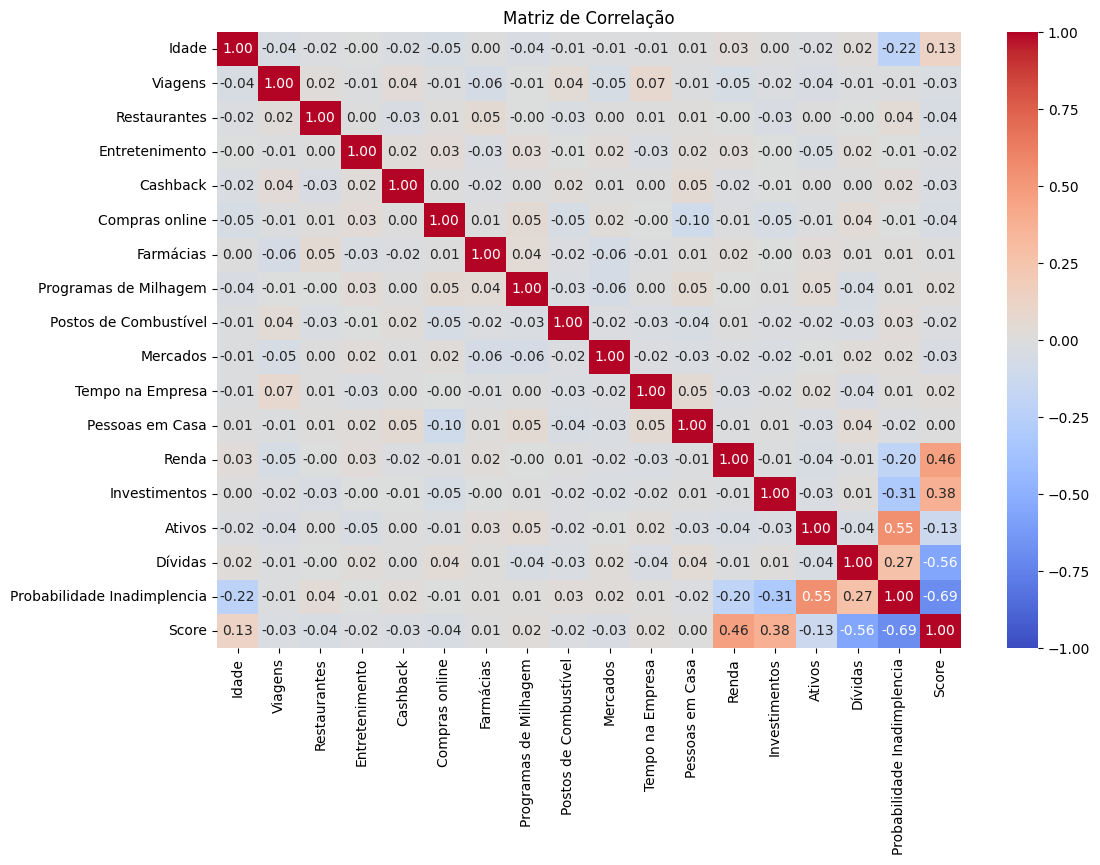

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(df_clientes[num_vars].corr(),vmin=-1,vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlação")
plt.show()

## Testes de Hipóteses

In [20]:
for cat_col in cat_vars:
    contingency_table = pd.crosstab(df_clientes[cat_col], df_clientes[target])
    chi2, p, dof, _ = chi2_contingency(contingency_table)
    print(f'{Fore.RED if p < 0.05 else Fore.WHITE}'
          f'Teste Qui-Quadrado entre {cat_col} e {target}: p-valor = {p}')

Teste Qui-Quadrado entre Cidade e Probabilidade Inadimplencia: p-valor = 0.3840071939383141
Teste Qui-Quadrado entre Cargo e Probabilidade Inadimplencia: p-valor = 0.12537953599869553
Teste Qui-Quadrado entre Estado Civil e Probabilidade Inadimplencia: p-valor = 0.48352948196643847
Teste Qui-Quadrado entre Moradia e Probabilidade Inadimplencia: p-valor = 0.37283145381687693
Teste Qui-Quadrado entre Principal Cartão e Probabilidade Inadimplencia: p-valor = 1.0


## Treinar RandomForestRegressor 

In [22]:
selected_features = ['Idade', 'Renda','Investimentos', 'Ativos','Dívidas']
X = df_clientes[selected_features]
y = df_clientes[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)

model = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(model,X_train,y_train, cv=5,scoring='neg_root_mean_squared_error')

print(f'RMSE Médio na validação cruzada: {-cv_scores.mean():.2f}')

RMSE Médio na validação cruzada: 6.48


In [23]:
def objetive(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
    }

    model = RandomForestRegressor(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3,scoring='neg_root_mean_squared_error').mean()

    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objetive,n_trials=100)

best_params = study.best_params
best_metric = study.best_value
print(f'Melhores parâmetros: {best_params}')
print(f'Melhor métrica : {best_metric}')

[I 2026-01-24 22:02:54,704] A new study created in memory with name: no-name-29dabf95-20e5-4d58-84fe-e6081a60d010
[I 2026-01-24 22:02:55,287] Trial 0 finished with value: 6.756761653874201 and parameters: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 0 with value: 6.756761653874201.
[I 2026-01-24 22:02:55,634] Trial 1 finished with value: 6.748466924709054 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 6}. Best is trial 1 with value: 6.748466924709054.
[I 2026-01-24 22:02:56,002] Trial 2 finished with value: 6.493143272558666 and parameters: {'n_estimators': 120, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 2 with value: 6.493143272558666.
[I 2026-01-24 22:02:56,428] Trial 3 finished with value: 8.289255538363259 and parameters: {'n_estimators': 182, 'max_depth': 5, 'min_samples_split': 10}. Best is trial 2 with value: 6.493143272558666.
[I 2026-01-24 22:02:56,591] Trial 4 finished with value: 8.687779822788718 and p

Melhores parâmetros: {'n_estimators': 93, 'max_depth': 10, 'min_samples_split': 2}
Melhor métrica : 6.4415763935061


## Treino e Avaliação final

In [25]:
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)
rsme = root_mean_squared_error(y_test, y_pred)
print(f'RMSE no conjunto de teste: {rsme:.2f}')

RMSE no conjunto de teste: 5.50


## Salvar o modelo

In [26]:
joblib.dump(best_model,'modelo_inadimplencia.pkl')

['modelo_inadimplencia.pkl']

## Abrir Base de Prospects

In [27]:
df_prospects = pd.read_csv('./prospect.csv')

In [28]:
df_prospects.info()

<class 'pandas.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   ID_Prospect            500 non-null    str  
 1   Nome                   500 non-null    str  
 2   Idade                  500 non-null    int64
 3   Viagens                500 non-null    int64
 4   Restaurantes           500 non-null    int64
 5   Entretenimento         500 non-null    int64
 6   Cashback               500 non-null    int64
 7   Compras online         500 non-null    int64
 8   Farmácias              500 non-null    int64
 9   Programas de Milhagem  500 non-null    int64
 10  Postos de Combustível  500 non-null    int64
 11  Mercados               500 non-null    int64
 12  Cidade                 500 non-null    str  
 13  Cargo                  500 non-null    str  
 14  Estado Civil           500 non-null    str  
 15  Tempo na Empresa       500 non-null    int64
 16  P

In [29]:
display(df_prospects.head())

,ID_Prospect,Nome,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas
0,de943fb0-5e23-4e7f-8130-1aa76b33f4dc,Francisco Fonseca,24,1,1,4,5,4,1,5,1,2,Brasília,Coach,Divorciado,14,6,Próprio,True,46006,736831,371505,88180
1,5050d0e5-5d35-4cb1-a208-596a3ee4ac1d,Melissa Mendes,58,1,4,5,3,2,3,3,1,2,São Paulo,Especialista em agronegócios,Solteiro,4,2,Próprio,False,38086,374702,1828554,31206
2,435005c0-50ea-4755-acef-b4362c08dccd,Lucca Costa,18,2,4,1,1,3,1,3,2,2,Campo Grande,Cobaia Médica,Divorciado,20,6,Próprio,False,42531,933858,1295274,178144
3,4e9951b4-1790-484c-ab25-189aa9089241,Francisco da Luz,20,4,3,1,4,1,4,2,2,4,Manaus,Classificador contábil,Solteiro,11,6,Próprio,True,16112,698799,1574952,434757
4,cb434840-2bf0-4516-8a79-8c9ada489c03,Sr. Vinícius Costela,22,1,1,4,3,5,2,3,1,2,Goiânia,Sapateiro,Solteiro,0,3,Próprio,True,3059,920950,449866,224609


## Mostrar estatisticas das variaveis numericas

In [38]:
# df_prospects.drop(columns=['ID_Prospect','Nome'], inplace=True)

num_vars = df_prospects.select_dtypes(include=['number']).columns
cat_vars = df_prospects.select_dtypes(include=['object']).columns
target = 'Probabilidade Inadimplencia'
display(df_prospects[num_vars].describe().T)

/tmp/ipykernel_277152/1619525562.py:4: Pandas4Warning:

For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.



,count,mean,std,min,25%,50%,75%,max
Idade,500.00000,48.13800,18.11705,18.00000,32.00000,48.00000,63.25000,80.00000
Viagens,500.00000,2.94800,1.42877,1.00000,2.00000,3.00000,4.00000,5.00000
Restaurantes,500.00000,3.12600,1.43466,1.00000,2.00000,3.00000,4.00000,5.00000
Entretenimento,500.00000,3.00600,1.43040,1.00000,2.00000,3.00000,4.00000,5.00000
Cashback,500.00000,2.91400,1.42782,1.00000,2.00000,3.00000,4.00000,5.00000
Compras online,500.00000,2.93600,1.39420,1.00000,2.00000,3.00000,4.00000,5.00000
Farmácias,500.00000,2.95800,1.36967,1.00000,2.00000,3.00000,4.00000,5.00000
Programas de Milhagem,500.00000,3.08000,1.45528,1.00000,2.00000,3.00000,4.00000,5.00000
Postos de Combustível,500.00000,2.98800,1.42967,1.00000,2.00000,3.00000,4.00000,5.00000
Mercados,500.00000,2.99200,1.41561,1.00000,2.00000,3.00000,4.00000,5.00000


In [39]:


for col in cat_vars:
    print(f'\n{col}: {df_prospects[col].nunique()} valores únicos')
    print(df_prospects[col].value_counts().head())


Cidade: 15 valores únicos
Cidade
São Paulo        45
Florianópolis    44
Salvador         44
Manaus           42
Recife           38
Name: count, dtype: int64

Cargo: 365 valores únicos
Cargo
Bioquímico     6
Arrumadeira    5
Atendente      5
Agricultor     4
Digitador      3
Name: count, dtype: int64

Estado Civil: 4 valores únicos
Estado Civil
Divorciado    129
Solteiro      125
Viúvo         124
Casado        122
Name: count, dtype: int64

Moradia: 2 valores únicos
Moradia
Alugado    251
Próprio    249
Name: count, dtype: int64


In [40]:
num_cols = 3

num_rows = math.ceil(len(num_vars)/num_cols)

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

for i, var in enumerate(num_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    fig.add_trace(
        go.Histogram(x=df_prospects[var], name=var),
        row=row, col=col
    )

fig.update_layout(
    height=300 * num_rows,
    width=1200,
    title_text='Histograma das Variáveis Numéricas',
    showlegend=False
)

fig.show()

In [42]:
num_cols = 3

num_rows = math.ceil(len(num_vars)/num_cols)

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

for i, var in enumerate(cat_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1

    fig.add_trace(
        go.Bar(x=df_prospects[var].value_counts().index[:10],
               y=df_prospects[var].value_counts().values[:10],
               name=var),
        row=row, col=col
    )

fig.update_layout(
    height=500 * num_rows,
    width=1200,
    title_text='Gráfico de Barras das variáveis categóricas',
    showlegend=False
)

fig.show()

## Carregar o modelo

In [43]:
modelo = joblib.load('./modelo_inadimplencia.pkl')

In [44]:
selected_features = ['Idade','Renda','Investimentos','Ativos','Dívidas']
X_prospects = df_prospects[selected_features]

## Realizar predição

In [45]:
df_prospects['Probabilidade Inadimplencia'] = modelo.predict(X_prospects)
df_prospects['Probabilidade Inadimplencia'] = round(df_prospects['Probabilidade Inadimplencia'],2)

In [46]:
df_prospects.head()

,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia
0,24,1,1,4,5,4,1,5,1,2,Brasília,Coach,Divorciado,14,6,Próprio,True,46006,736831,371505,88180,59.00000
1,58,1,4,5,3,2,3,3,1,2,São Paulo,Especialista em agronegócios,Solteiro,4,2,Próprio,False,38086,374702,1828554,31206,52.02000
2,18,2,4,1,1,3,1,3,2,2,Campo Grande,Cobaia Médica,Divorciado,20,6,Próprio,False,42531,933858,1295274,178144,76.87000
3,20,4,3,1,4,1,4,2,2,4,Manaus,Classificador contábil,Solteiro,11,6,Próprio,True,16112,698799,1574952,434757,84.60000
4,22,1,1,4,3,5,2,3,1,2,Goiânia,Sapateiro,Solteiro,0,3,Próprio,True,3059,920950,449866,224609,62.78000


In [47]:
def calcular_score(row):
    renda_norm = min(row['Renda']/ 50000, 1)
    invest_norm = min(row['Investimentos']/ 1e6, 1)
    ativos_norm = min(row['Ativos']/ 2e6, 1)
    dividas_norm = min(row['Dívidas']/ 5e5, 1)

    score_base = (renda_norm*0.4 + invest_norm* 0.3 +ativos_norm *0.2 - dividas_norm* 0.4) * 100
    score_ajustado = score_base * (1 - (row['Probabilidade Inadimplencia']/ 100))
    
    return int(round(max(0, min(1000, score_ajustado))))

df_prospects['Score'] = df_prospects.apply(calcular_score, axis=1)

In [48]:
df_prospects.head()

,Idade,Viagens,Restaurantes,Entretenimento,Cashback,Compras online,Farmácias,Programas de Milhagem,Postos de Combustível,Mercados,Cidade,Cargo,Estado Civil,Tempo na Empresa,Pessoas em Casa,Moradia,Possui Carro,Renda,Investimentos,Ativos,Dívidas,Probabilidade Inadimplencia,Score
0,24,1,1,4,5,4,1,5,1,2,Brasília,Coach,Divorciado,14,6,Próprio,True,46006,736831,371505,88180,59.00000,23
1,58,1,4,5,3,2,3,3,1,2,São Paulo,Especialista em agronegócios,Solteiro,4,2,Próprio,False,38086,374702,1828554,31206,52.02000,28
2,18,2,4,1,1,3,1,3,2,2,Campo Grande,Cobaia Médica,Divorciado,20,6,Próprio,False,42531,933858,1295274,178144,76.87000,14
3,20,4,3,1,4,1,4,2,2,4,Manaus,Classificador contábil,Solteiro,11,6,Próprio,True,16112,698799,1574952,434757,84.60000,2
4,22,1,1,4,3,5,2,3,1,2,Goiânia,Sapateiro,Solteiro,0,3,Próprio,True,3059,920950,449866,224609,62.78000,6
